In [1]:
from definitions import *
from xmca.array import MCA
from xmca.xarray import xMCA
%load_ext autoreload
%autoreload 2

In [2]:
exp_wind = ClusteringExperiment('ERA5', 'Wind', '300', None, None, -60, 60, 20, 80, False, 'anomaly', 'JJA')
exp_T = ClusteringExperiment('ERA5', 'Temperature', '2m', 'box_-25_60_32_72', 't', None, None, None, None, False, 'anomaly', 'JJA')
da_wind = exp_wind.open_da()
da_T = exp_T.open_da()

In [3]:
X, da_wind = exp_wind.prepare_for_clustering()
Y, da_T = exp_T.prepare_for_clustering()

X = exp_wind.pca_transform(X, 150)
Y = exp_T.pca_transform(Y, 100)

# EOFs

# REOFS / FA

# EEOFs

# POPs

# $T_1$ OPPs

In [4]:
n_pcas = 150
lag_max = 90
autocorrs = []
for i in range(lag_max + 1):
    autocorrs.append(
        np.cov(X[i:], np.roll(X, i, axis=0)[i:], rowvar=False)[
            n_pcas:, :n_pcas
        ]
    )

autocorrs = np.asarray(autocorrs)
M = autocorrs[0] + np.sum(
    [autocorrs[i] + autocorrs[i].transpose() for i in range(1, lag_max + 1)],
    axis=0,
)

invsqrtC0 = linalg.inv(linalg.sqrtm(autocorrs[0]))
symS = invsqrtC0.T @ M @ invsqrtC0
eigenvals, eigenvecs = linalg.eigh(symS)
OPPs = autocorrs[0] @ (invsqrtC0 @ eigenvecs.T)
idx = np.argsort(eigenvals)[::-1]
eigenvals = eigenvals[idx]
OPPs = OPPs[idx]
results = {
    "eigenvals": eigenvals,
    "OPPs": OPPs,
}

# $T_2$ OPPs

In [33]:
from scipy.optimize import minimize

In [88]:
from numpy.typing import ArrayLike


n_pcas = 150
lag_max = 90
autocorrs = []
terms = []
for i in range(lag_max):
    autocorrs.append(
        np.cov(X[i:], np.roll(X, i, axis=0)[i:], rowvar=False)[
            n_pcas:, :n_pcas
        ]
    )
autocorrs = np.asarray(autocorrs)
C0minushalf = linalg.inv(linalg.sqrtm(autocorrs[0]))
basis = linalg.orth(C0minushalf)
xmin, xmax = np.amin(basis, axis=0), np.amax(basis, axis=0)
x0 = xmin + (xmax - xmin) * np.random.rand(len(xmax))

def T2(x) -> float:
    normxsq = linalg.norm(x) ** 2
    factor1 = x.T @ C0minushalf @ autocorrs @ C0minushalf @ x
    return np.sum(factor1 ** 2) / normxsq ** 2

def minus_T2(x) -> float:
    return - T2(x)

def T2_gradient(x) -> ArrayLike:
    normxsq = linalg.norm(x) ** 2
    factor1 = x.T @ C0minushalf @ autocorrs @ C0minushalf @ x
    numerator = np.sum((factor1)[:, None] * ((C0minushalf @ (autocorrs + autocorrs.transpose((0, 2, 1))) @ C0minushalf) @ x), axis=0)
    return numerator / normxsq ** 2 - 4 * T2(x) * x / normxsq ** 3

def minus_T2_gradient(x) -> ArrayLike:
    return - T2_gradient(x)

In [96]:
x0 = xmin + (xmax - xmin) * np.random.rand(len(xmax))
x = x0
result = 0
for it in range(10):
    res = minimize(minus_T2, x, jac=minus_T2_gradient, method='CG')
    newx = res.x
    dist = np.abs(result + res.fun)
    result = - res.fun
    x = newx / linalg.norm(newx)
    print(res)
    print(f'{it}, success={res.success}, T2={result}, {dist=:.2f}')
    if dist==0:
        break

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: -5.296877448887094
       x: [ 7.180e+05 -4.046e+05 ... -1.736e+04  8.669e+03]
     nit: 9
     jac: [-6.196e-06  3.198e-06 ...  1.354e-07 -8.444e-08]
    nfev: 91
    njev: 91
0, success=True, T2=5.296877448887094, dist=5.30
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: -5.296877448887092
       x: [ 6.363e-01 -3.586e-01 ... -1.538e-02  7.683e-03]
     nit: 0
     jac: [ 6.490e+00 -3.989e+00 ... -1.731e-01  6.751e-02]
    nfev: 38
    njev: 31
1, success=False, T2=5.296877448887092, dist=0.00
 message: Desired error not necessarily achieved due to precision loss.
 success: False
  status: 2
     fun: -5.296877448887092
       x: [ 6.363e-01 -3.586e-01 ... -1.538e-02  7.683e-03]
     nit: 0
     jac: [ 6.490e+00 -3.989e+00 ... -1.731e-01  6.751e-02]
    nfev: 38
    njev: 31
2, success=False, T2=5.296877448887092, dist=0.00


In [100]:
from scipy.optimize import basinhopping

basinhopping(minus_T2, x0, minimizer_kwargs=dict(jac=minus_T2_gradient), niter=300)

# DMFs

# CCA / MCA

In [62]:
pca = MCA(X, Y)
pca.normalize()
pca.solve()

In [48]:
svals_rule_n = pca.rule_n(n_runs=1000)

100%|██████████| 1000/1000 [02:28<00:00,  6.74it/s]


In [51]:
q99 = np.quantile(svals_rule_n, 0.99, axis=1)

In [52]:
np.argmax(svals < q99)

25

In [66]:
eofs = pca.eofs(n=80, scaling='max')
pcs = pca.pcs(n=80, scaling='max')

In [69]:
eofs['left'].shape

(150, 80)

In [75]:
eofs_realspace = {
    'left': exp_wind.to_dataarray(eofs['left'].T, da_wind, 150),
    'right': exp_T.to_dataarray(eofs['right'].T, da_T, 100),
}

In [ ]:
eofs_realspace

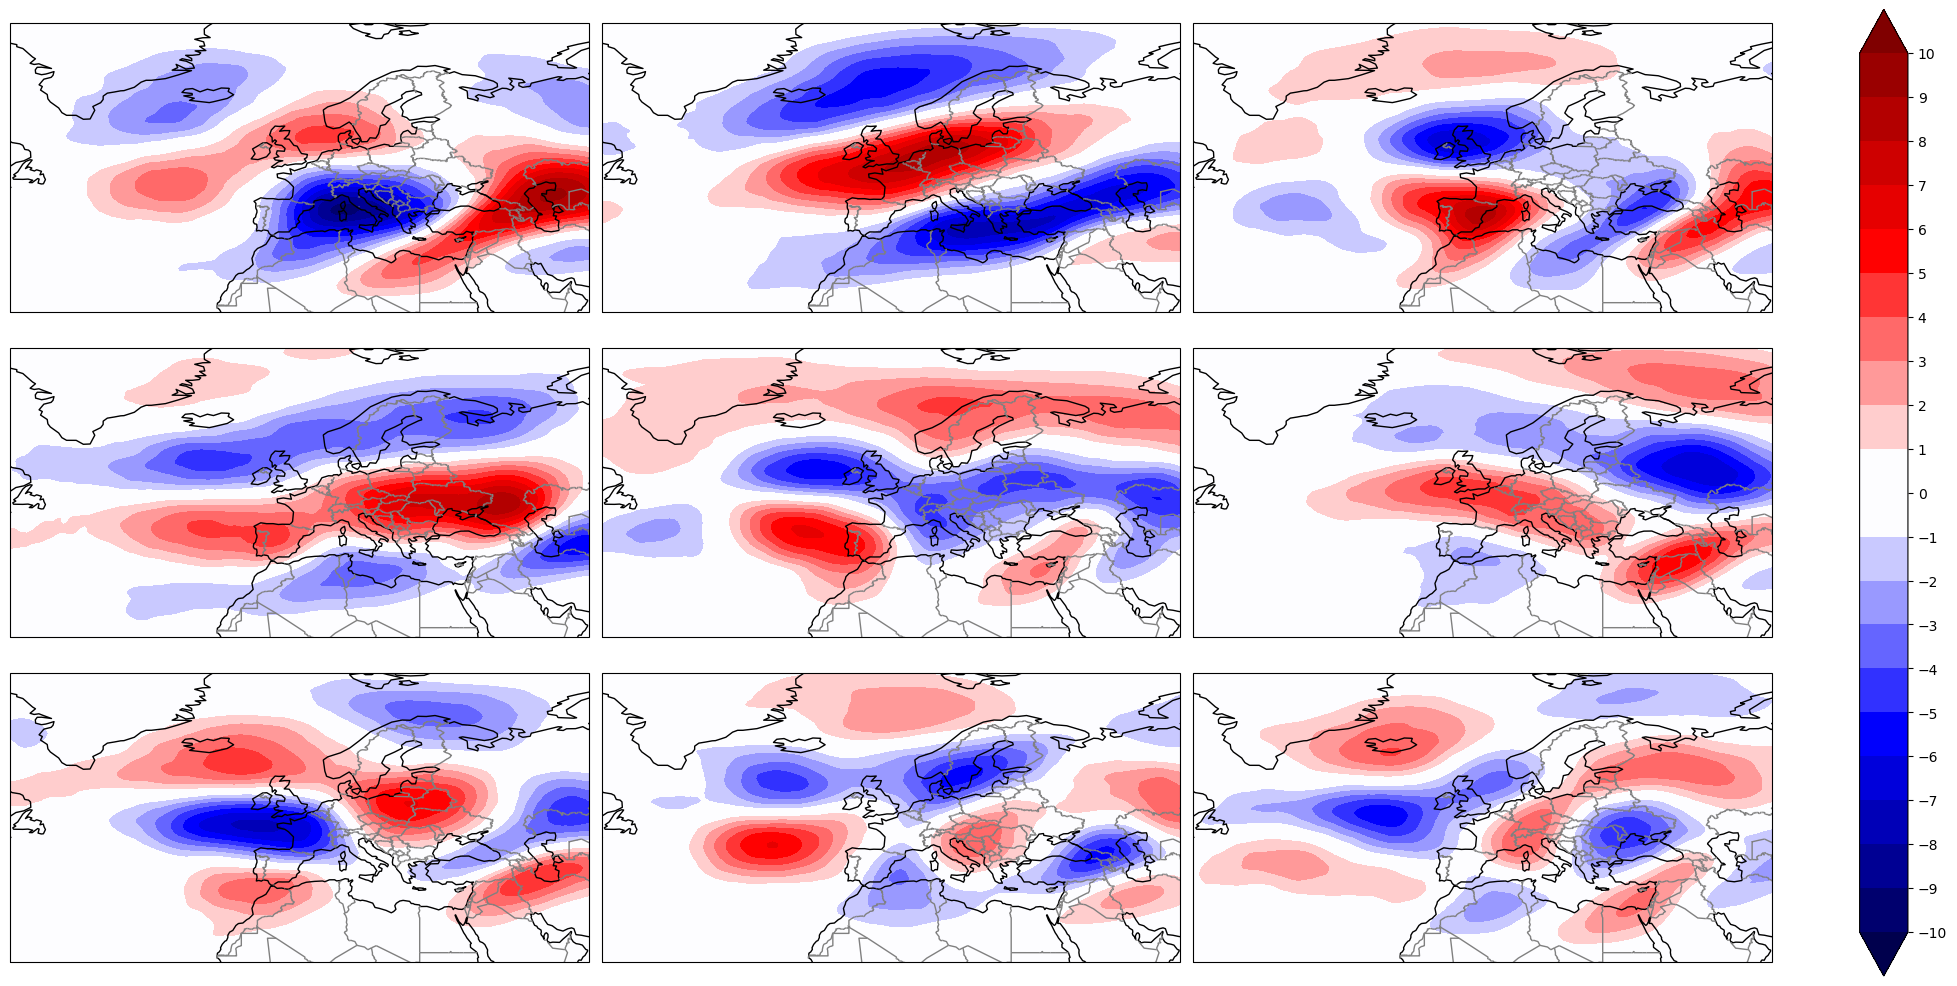

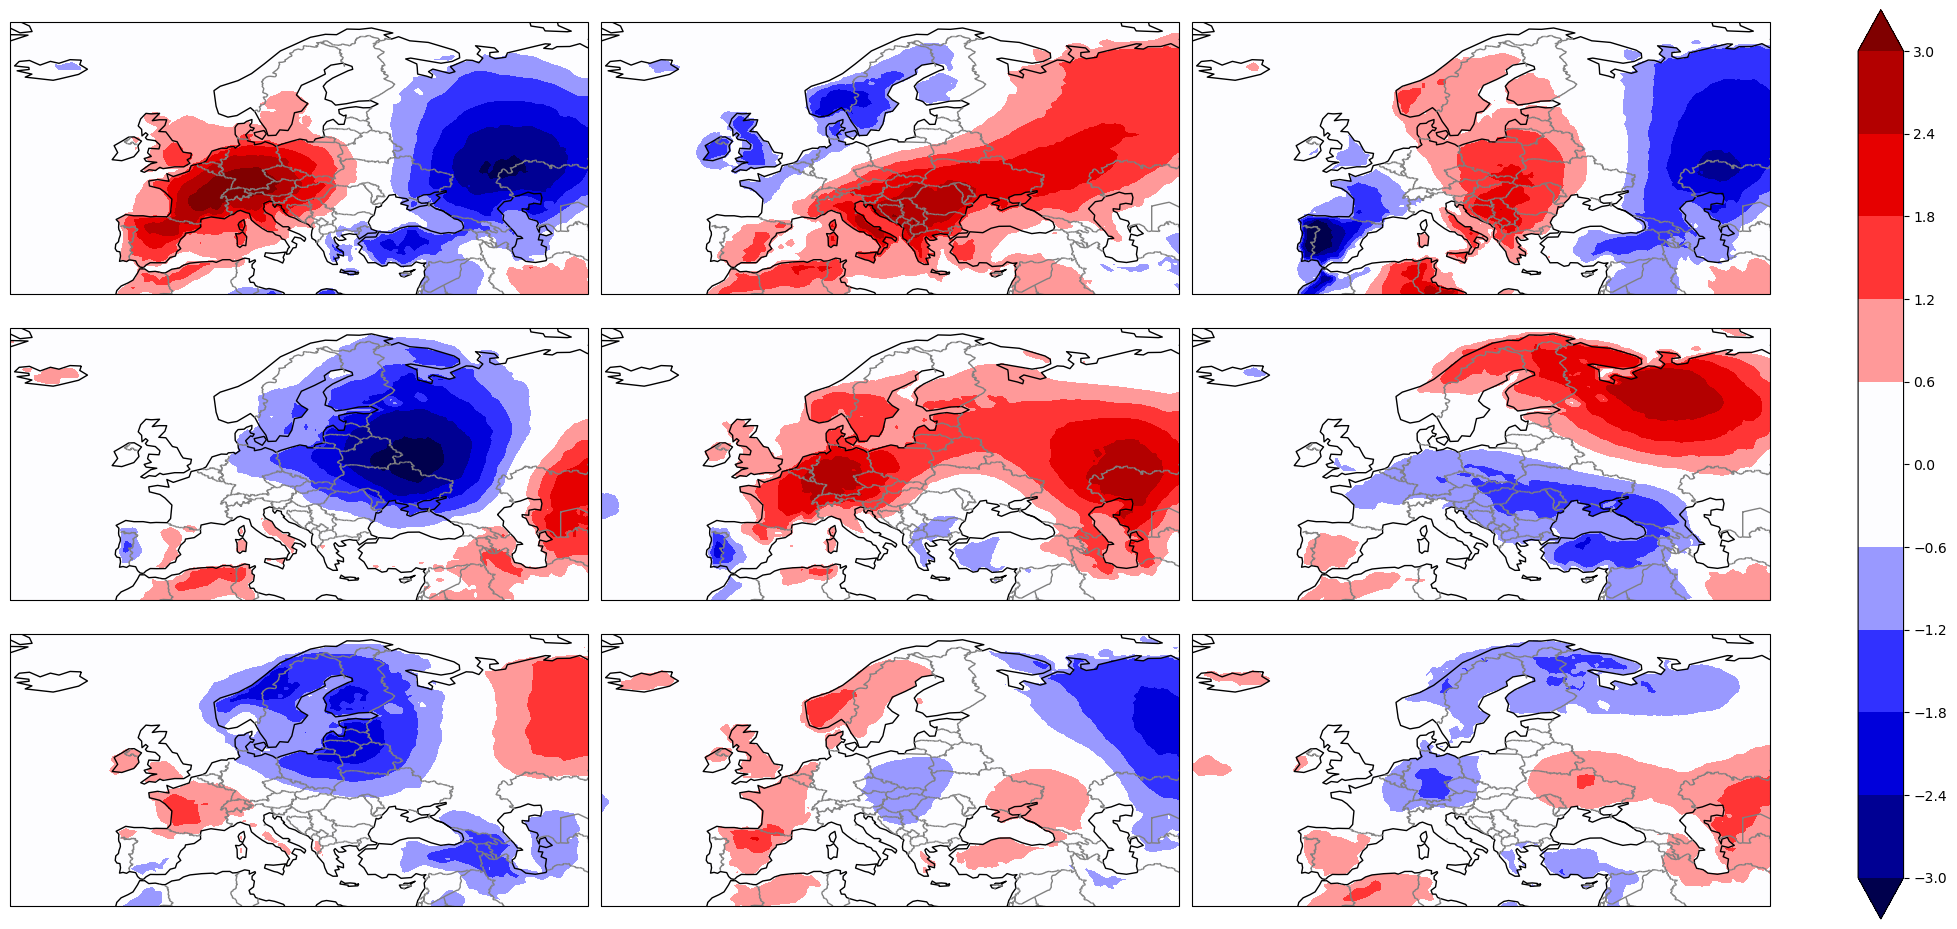

In [79]:
to_plot = {key : [eofs_realspace[key].isel(mode=i) for i in range(9)] for key in eofs}

fig, axes, cbar = clusterplot(3, 3, to_plot['left'], 11, 10, clabels=None, contours=False)
fig, axes, cbar = clusterplot(3, 3, to_plot['right'], 6, 3, clabels=None, contours=False)

# to_plot = [da.isel(time=mask_high_val[:, i]).mean(dim='time') for i in range(6)]
# levels = 12
# levels2 = int(levels / 2)
# colors = levels2 * ['sienna'] + (levels2 + 1) * ['green']
# linestyles = levels2 * ['dashed'] + (levels2 + 1) * ['solid']
# for ax, toplt, eigenval in zip(axes, to_plot, eigenvals):
#     toplt.plot.contour(ax=ax, add_colorbar=False, add_labels=False, levels=levels, vmin=-10, vmax=10, colors=colors, linestyles=linestyles)
#     ax.set_title(f'{eigenval:.2f}')